In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates


In [37]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [41]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)
one_year_ago


2016-08-23


datetime.date(2016, 8, 23)

In [46]:

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp, measurement.tobs).filter(
    measurement.date >= one_year_ago,
    measurement.date <= dt.date(2017, 8, 23),
).all()

# Collect the data in lists
# ids = []
# stations = []
dates = []
precipitations = []
temperatures = []

for result in results:
    # ids.append(result.id)
    # stations.append(result.station)
    dates.append(result.date)
    precipitations.append(result.prcp)
    temperatures.append(result.tobs)


In [47]:
# Save the query results as a Pandas DataFrame
last_year = pd.DataFrame({
    'Date': dates,
    'Precipitation': precipitations,
    'Temperature': temperatures,
})

# Print or use the DataFrame as needed
last_year.head()

,Date,Precipitation,Temperature
0,2016-08-23,0.00,81.0
1,2016-08-24,0.08,79.0
2,2016-08-25,0.08,80.0
3,2016-08-26,0.00,79.0
4,2016-08-27,0.00,77.0


In [59]:
# Sort the dataframe by date
sorted_last_year = last_year.sort_values('Date', ascending=True)
sorted_last_year.head()

,Date,Precipitation,Temperature
0,2016-08-23,0.00,81.0
1009,2016-08-23,NaN,80.0
1529,2016-08-23,1.79,77.0
704,2016-08-23,0.05,80.0
361,2016-08-23,0.15,76.0


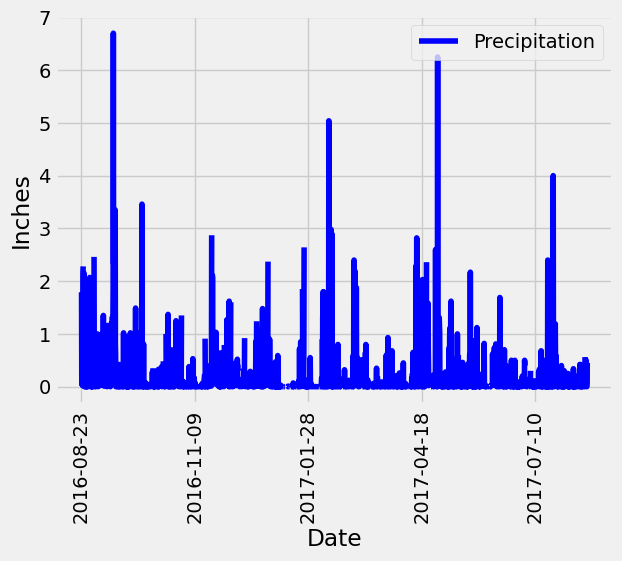

In [62]:
# Plot the precipitation over the last year
sorted_last_year.plot(x='Date', 
                      y='Precipitation', 
                      kind='line',
                      xlabel='Date', 
                      ylabel='Inches',
                      color='blue')

# Show the legend on the top right
plt.legend(['Precipitation'], loc='upper right')

plt.xticks(rotation=90)

# Show the plot
plt.show()

In [50]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = sorted_last_year['Precipitation'].describe()

# Display the summary statistics
print(precipitation_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [51]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [52]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Design a query to find the most active stations and their row counts
active_stations_query = session.query(
    measurement.station,
    func.count().label('row_count')
).group_by(measurement.station).order_by(func.count().desc())

# Execute the query and fetch the results
active_stations_results = active_stations_query.all()

# Print the results
for station, row_count in active_stations_results:
    print(f"Station: {station}, Row Count: {row_count}")

Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp_station = session.query(
    func.min(measurement.tobs), 
    func.avg(measurement.tobs), 
    func.max(measurement.tobs)
).filter(measurement.station == 'USC00519281').first()
print(f'lowest temp: {lowest_temp_station}')

highest_temp_station = session.query(
    func.max(measurement.tobs)
).filter(measurement.station == 'USC00519281').first()
print(f'highest temp: {highest_temp_station}')

avg_temp_station = session.query(
    func.avg(measurement.tobs)
).filter(measurement.station == 'USC00519281').first()
print(f'average temp: {avg_temp_station}')

lowest temp: (54.0,)
highest temp: (85.0,)
average temp: (71.66378066378067,)


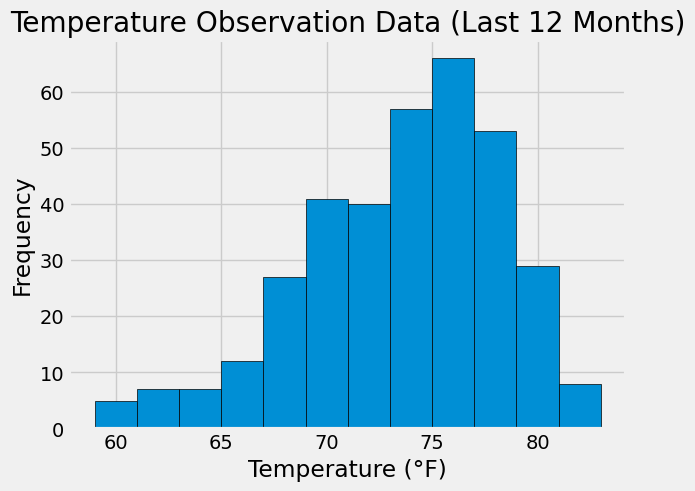

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measurement.date, measurement.tobs).filter(
    measurement.station == 'USC00519281',
    measurement.date >= dt.date(2016, 8, 23),
    measurement.date <= dt.date(2017, 8, 23),
).all()

# Convert the results to a DataFrame
df = pd.DataFrame(results, columns=['date', 'temperature'])
df.set_index('date', inplace=True)

# Plot the results as a histogram
plt.hist(df['temperature'], bins=12, edgecolor='black')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Close Session

In [55]:
# Close Session
session.close()